In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [2]:
def get_img_mat(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return img_array

def get_gray_img_mat(img_path):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    return img_array


In [136]:

#this method is use to expand an image size by 2 (both width and height)
#it uses zero padding (0, a1, 0, a2, 0, a3, ... , 0, an) to expand the image
# and then perform blur with gaussian filter with normalized kernel to 2 in order to fill the 0s
def expand_image(img, expanded_size):
    #create the expanded image
    expanded_img = np.zeros(expanded_size)
    # Iterate over the rows and columns of the smaller array (img) #TODO maybe improve
    for i in range(expanded_img.shape[0]):
        for j in range(expanded_img.shape[1]):
            # Only fill in values where it won't change the shape of expanded_img
            if i * 2 < expanded_img.shape[0] and j * 2 < expanded_img.shape[1] and i < img.shape[0] and j < img.shape[1]:
                expanded_img[i * 2, j * 2] = img[i, j]
    #create the gaussian kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/4
    #perform the blur
    expanded_img = np.round(convolve2d(expanded_img, kernel))
    return expanded_img

#implement the convolution
def convolve2d(image, kernel):
    #get the kernel size
    kernel_size = kernel.shape[0]
    #get the image size
    image_height, image_width = image.shape
    #get the padding size
    padding_size = kernel_size//2
    #create the padded image
    padded_image = np.pad(image, padding_size, mode="constant")
    #create the result image
    result = np.zeros(image.shape)
    #perform the convolution
    for i in range(image_height):
        for j in range(image_width):
            result[i, j] = np.sum(padded_image[i:i+kernel_size, j:j+kernel_size]*kernel)
    return result


def reduce_image(img, reduced_size, should_blur=True):
    #create the reduced image
    reduced_img = np.zeros(reduced_size)
    #create the gaussian kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16
    #perform the blur
    if should_blur:
        img = np.round(convolve2d(img, kernel))
    # Iterate over the rows and columns of the smaller array (img) #TODO maybe improve
    for i in range(reduced_img.shape[0]):
        for j in range(reduced_img.shape[1]):
            reduced_img[i, j] = img[i * 2, j * 2]
    return reduced_img

def get_reduced_size(img, factor=2):
    return (img.shape[0]//factor, img.shape[1]//factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1])))-1

def create_pyramid(img):
    pyramid = []
    pyramid.append({'G' : img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size)
        expanded_image_size = pyramid[i-1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})
        
    for i in range(len(pyramid)-1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i+1]['Expanded_G']
    return pyramid

def plot_pyramid(pyramid):
    plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)):
        plt.subplot(1, len(pyramid), i+1)
        plt.imshow(pyramid[i]['G'], cmap="gray")
        plt.title(f"Level {i}")
    plt.show()

def plot_pyramid_diff(pyramid):
    plt.subplots(1, len(pyramid)-1, figsize=(20, 20))
    for i in range(len(pyramid)-1):
        plt.subplot(1, len(pyramid)-1, i+1)
        plt.imshow(pyramid[i]['L'], cmap="gray")
        plt.title(f"Level {i} - Level {i+1}")
    plt.show()


def get_mask_pyramid(mask):
    mask = mask//255
    mask_pyramid = []
    mask_pyramid.append({'G' : mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size, False)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid       


def reconstruct_image(pyramid):
    reconstructed_img = pyramid[-1]['G']
    for i in range(len(pyramid)-2, -1, -1):
        expanded_img = expand_image(reconstructed_img, pyramid[i]['L'].shape)
        reconstructed_img = expanded_img + pyramid[i]['L']
    return reconstructed_img


def blend_pyramids(pyramid1, pyramid2, mask_pyramid):
    blended_pyramid = []
    for i in range(len(pyramid1)-1):
        blended_pyramid.append({'L': pyramid1[i]['L']*mask_pyramid[i]['G'] + (1-mask_pyramid[i]['G'])*pyramid2[i]['L']})
    blended_pyramid.append({'G': pyramid1[-1]['G']*mask_pyramid[-1]['G'] + (1-mask_pyramid[-1]['G'])*pyramid2[-1]['G']})
    return blended_pyramid


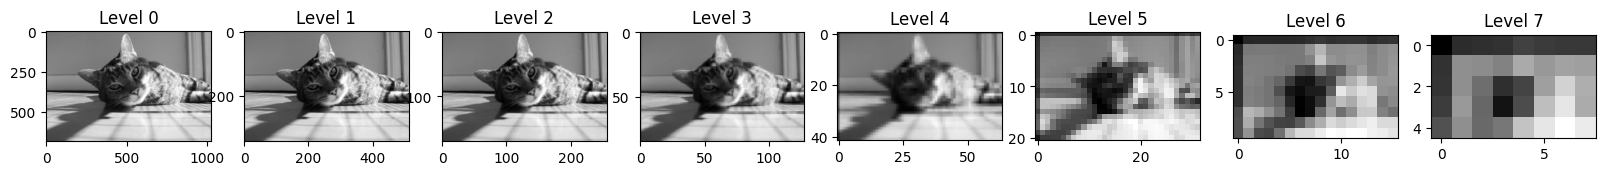

In [129]:
img = get_gray_img_mat('./assets/grayscale-cat.jpeg')
pyramid = create_pyramid(img)
plot_pyramid(pyramid)

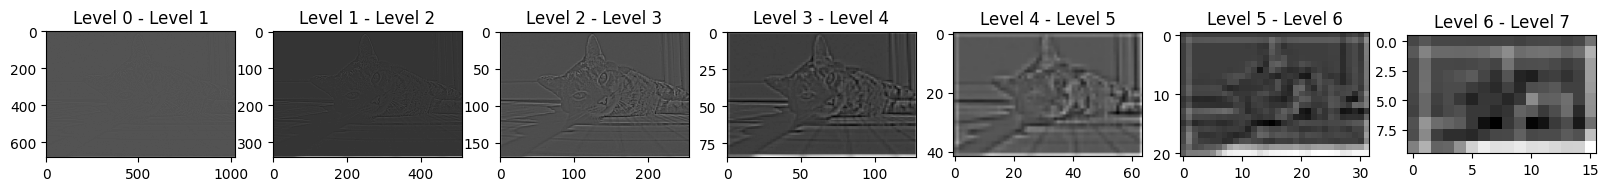

In [130]:
plot_pyramid_diff(pyramid)


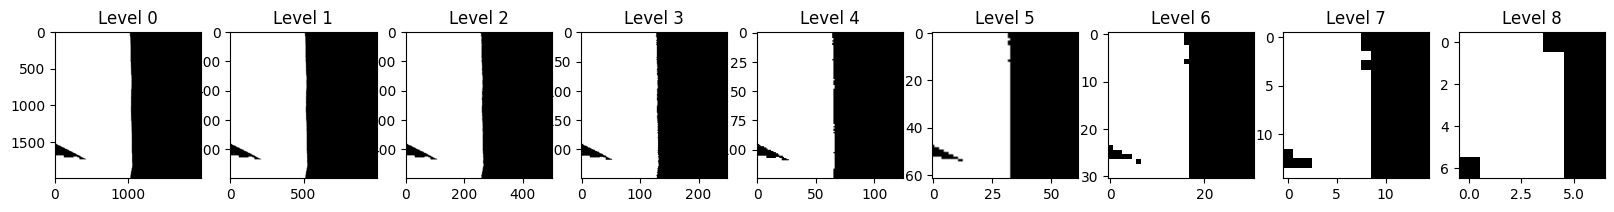

In [135]:
mask = get_gray_img_mat('./assets/mask.jpeg')
mask_pyramid = get_mask_pyramid(mask)
plot_pyramid(mask_pyramid)

In [122]:
apple_img = get_gray_img_mat('./assets/apple.jpeg')
apple_pyramid = create_pyramid(apple_img)
orange_img = get_gray_img_mat('./assets/orange.jpeg')
orange_pyramid = create_pyramid(orange_img)

In [124]:
blended_pyramid = blend_pyramids(apple_pyramid, orange_pyramid, mask_pyramid)


In [126]:
blended_img = reconstruct_image(blended_pyramid)

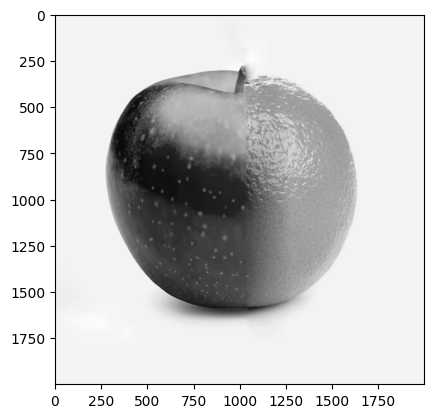

In [127]:
plt.imshow(blended_img, cmap='gray')